In [1]:
%load_ext autoreload
%autoreload 2

# qd_lasing_dynamics package Tutorial

This package is for analyzing quantum dot lasing dynamics in a Baysian framework.  It has objects for defining priors, the model, and doing Baysian parameter estimation with emcee.  

## Model Definition

Our theoretical model is the solution set to a set of three rate equations (see below). In this model, as is described in [1], it is assumed that carriers are injected into a quantum well and then are subsequently captured by quantum dots for radiative recombination. These coupled rate equations relate Photon Density, Quantum Dot occupation probability, and Carrier Density in the quantum well:

$$
\dot{S} = -\frac{S}{\tau_s} + g_0v(2\rho-1)S \tag{1}
$$

$$
\dot{\rho} = -\frac{\rho}{\tau_d} - g_0(2\rho-1)S + F(N,\rho) \tag{2}
$$

$$
\dot{N} = J - \frac{N}{\tau_n} - 2N_dF(N,\rho) \tag{3}
$$

Where S is photon density; N is carrier density in the quantum well; $\rho$ is the occupation probability in a quantum dot; $\tau_s$ is the photon lifetime; $\tau_n$ and $\tau_d$ are the carrier lifetimes in the well and the dot, respectively; $N_d$ is the 2D density of Quantum Dots, and J is the pump current density. $g_0 = \sigma_{res}v_g$, where $\sigma_{res}$ is the cross section of interaction of carriers in the dots with photons; $v_g$ is the group velocity; and $v = 2N_d\Gamma/d$, where $\Gamma$ is the confinement factor and $d$ is the thickness of the dot layer.

Additionally,

$$
F(N,\rho) = R_{cap}(1-\rho)-R_{esc}\rho \tag{4}
$$

Where $R_{cap} = CN^2 + BN$. C describes Auger carrier capture while B describes carrier-phonon capture. $R_{esc}$ is the rate of escape of carriers from quantum dots and is a temperature dependent function. 

By solving equations 1-3 in steady state, we can define S, $\rho$, and N in terms of input current, or J. Therefore, the S function in terms of J is essentially your "lasing curve". This curve will be what we are "fitting" our data to, as this is the format our data is in. 

When taking lasing curves on our devices, there is a gaussian distribution of noise with standard deviation X units, which will be our likelihood. Additionally, we will be assuming a flat prior for our C coefficient, or the Auger capture rate. Therefore, our statistical model will be:

$$
y_i = Normal(\mu, \sigma)
$$

$$
\mu = Steady state solution to equations 1-3
$$

$$
C \simeq Uniform(10^{-19}, 10^{-20})m^4/s
$$

## Objects

### Prior objects

Recall,

$$p(x) = \frac{1}{x_{\mathrm{max}}-x_{\mathrm{min}}}$$ (Uniform Prior)


In [2]:
from numpy import exp
import emcee
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# we'll make use of seaborn's features, so make sure you've 
# installed it using conda
import seaborn as sns
from scipy.optimize import fsolve
from example.inference.model import JefferysPrior, UniformPrior, LogLikelihood
from data_files.io import get_example_data_file_path, load_data

## Example of likelihood and posterior calculation using a Uniform Prior

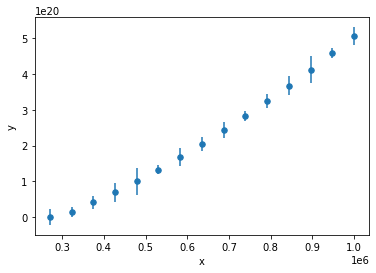

In [8]:
import pandas as pd

simulated_data_frame = load_data(get_example_data_file_path('simulated_data_csv.csv'))

x = simulated_data_frame['x'][:]
y = simulated_data_frame['y'][:]
sigma_y = simulated_data_frame['sigma_y'][:]

## plot the test data
simulated_data_frame.plot(x='x', y='y', kind='scatter', yerr='sigma_y', s=30)

def log_posterior(theta, x, y, sigma_y):
    return UniformPrior(10e-21, 10e-19).logp(10e-20) + LogLikelihood(theta, x, y, sigma_y).logllh()

In [9]:
# the model has 1 parameters; we'll use 50 walkers and 500 steps each
ndim = 1
nwalkers = 50
nsteps = 500

# Here's an initial guess slightly off from the paper's parameter value
# to show how the MCMC equilibrates to the correct value
ls_result = [0.8e-20] 
gaussian_ball = 1e-4 * np.random.randn(nwalkers, ndim)
starting_positions = (1 + gaussian_ball) * ls_result

In [10]:
# set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, 
                                args=(x, y, sigma_y))
# run the sampler. We use iPython's %time directive to tell us 
# how long it took (in a script, you would leave out "%time")
%time sampler.run_mcmc(starting_positions, nsteps)
print('Done')

C:\Users\rauna\Anaconda2\envs\phys201\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\rauna\Anaconda2\envs\phys201\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)
C:\Users\rauna\Anaconda2\envs\phys201\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Wall time: 6min 9s
Done


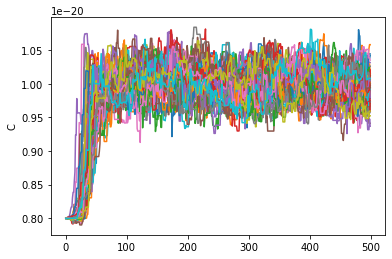

In [11]:
fig, (ax_C) = plt.subplots(1)
ax_C.set(ylabel='C')
for i in range(50):
    # to use seaborn's lineplot, we first need to make a dataframe
    df = pd.DataFrame({'C': sampler.chain[i,:,0]})
    sns.lineplot(data=df, x=df.index, y='C', ax=ax_C)

In [12]:
samples = sampler.chain[:,100:,:]
# reshape the samples into a 1D array where the colums are m and b
traces = samples.reshape(-1, ndim).T
# create a pandas DataFrame with labels.  This will come in handy 
# in a moment, when we start using seaborn to plot our results 
# (among other things, it saves us the trouble of typing in labels
# for our plots)
parameter_samples = pd.DataFrame({'C': traces[0]})

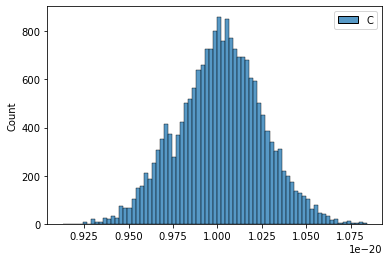

In [13]:
joint_kde = sns.histplot(data=parameter_samples)

### References
1. O’Brien, D., Hegarty, S.P., Huyet, G. and Uskov, A.V., 2004. Sensitivity of quantum-dot semiconductor lasers to optical feedback. Optics letters, 29(10), pp.1072-1074.